# Sea ice sensitivity to temperature in CMIP6 Models: 

CMIP6 Hackathon UW  
October 2019  
Robin Clancy, Maddie Smith, Katie Brennan, and Ed Blanchard 
  
#### Motivation:
The state of global sea ice is strongly related to changes in the mean temperature. This is in part a result of the sea ice-albedo feedback, which amplities ice loss with increases in Arctic air temperature. 
Various studies have shown that Arctic sea ice loss is underestimated when compared to observations in previous CMIPs (i.e. Stroeve et al., 2012). It's unclear if this is due to differences in Arctic warming or differences in the sensitivity of sea ice concentrations to warming.

#### Goals:
Here we aim to quantify the senstivity between Arctic surface air temperature and sea ice across different models. We want to investigate: how strong is this relationship, what is the seasonal variation in the relationship, and how much variability is there across models. 


In [1]:
%matplotlib inline

import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats

import util
import siutils as si

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
import importlib
importlib.reload(si)

<module 'siutils' from '/home/jovyan/v2/cmip6-seaice-temp-sensitivity/notebooks/siutils.py'>

In [3]:
def scatter_tas_SIE_linreg(TAS_ARCTIC_IN,SIE_ARCTIC_IN,MONTHS_IN,PLOTFLAG,MODEL):
    import calendar
    slopes_all = []
    r_all = []
    if PLOTFLAG == True:
        fig = plt.figure(figsize=(12,5))
    for m,mi in enumerate(MONTHS_IN):
        CESM_airtemp_mi = TAS_ARCTIC_IN[mi::12].values
        CESM_extent_mi = SIE_ARCTIC_IN[mi::12].isel(time=slice(0,165)).values
        monthname = calendar.month_name[mi+1]

        slope,intercept,r_value, p_value, std_err = stats.linregress(CESM_airtemp_mi,CESM_extent_mi/1e12)
        slopes_all.append(slope)
        r_all.append(r_value)
        
        if PLOTFLAG == True:
            ax = fig.add_subplot(1,len(MONTHS_IN),m+1)
            ax.scatter(CESM_airtemp_mi,CESM_extent_mi/1e12)
            ax.plot(CESM_airtemp_mi, intercept + slope*CESM_airtemp_mi, 'r')
            ax.set_title(monthname+', slope: %f  ' % (slope))
            #print("slope: %f  " % (slope))
            ax.set_xlabel('Temp (K)')
            ax.set_ylabel('SIE (millions km$^2$)')
            fig.suptitle(MODEL)

    if PLOTFLAG == True:
        plt.show()
    return slopes_all, r_all

### Find data: 

In [4]:
#Get full catalogue of CMIP6 data on glade or cloud
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [5]:
# Find file names for various specifications
cat_siconc = col.search(experiment_id=['historical'],table_id='SImon', 
                        variable_id='siconc', grid_label='gn')

cat_cellarea = col.search(experiment_id=['historical'],table_id='Ofx', 
                          variable_id='areacello', grid_label='gn')

cat_tas = col.search(experiment_id=['historical'],table_id='Amon', 
                          variable_id='tas', grid_label='gn')

In [6]:
# Find where models contain all necessary variables
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])

models_intersect = set(uni_dict['source_id']['values']) # all the models
table_id = ['SImon','Ofx','Amon']
var_list = ['siconc','areacello','tas']
exp = 'historical'

models_intersect = si.find_overlap_models(var_list,exp,table_id,models_intersect,col)

### Load data: 

In [7]:
ardset_dict = cat_cellarea.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                           cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 13 group(s)


In [8]:
sidset_dict = cat_siconc.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [9]:
tasdset_dict = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


#### Clean data: 

In [10]:
# Creates dictionary relating model names to file names
amodel_name_dict = {ardset_dict[x].attrs['source_id']: x for x in ardset_dict}
smodel_name_dict = {sidset_dict[x].attrs['source_id']: x for x in sidset_dict}
tmodel_name_dict = {tasdset_dict[x].attrs['source_id']: x for x in tasdset_dict}

In [11]:
# Adding areacello as variable in other datasets and making key of dataset model name
si_dict_temp = {}
tas_dict = {}

for key, item in sidset_dict.items():
    model = item.attrs['source_id']
    if model in models_intersect: 
        si_dict_temp[model] = item
        si_dict_temp[model]['areacello'] = ardset_dict[amodel_name_dict[model]]['areacello']
        tas_dict[model] = tasdset_dict[tmodel_name_dict[model]]

### Set single model to look at

In [157]:
print(models_intersect)
m=models_intersect[5] #Will loop over all of these later
print(m)

['CanESM5', 'CESM2', 'MIROC-ES2L', 'MIROC6', 'NorCPM1', 'SAM0-UNICON']
SAM0-UNICON


In [158]:
# Rename dimensions so they're all the same: 
si_dict = {}
for m in models_intersect:
    si_dict[m] = si.rename_dimensions(si_dict_temp[m],si_dict)

#### Calculate total Arctic sea ice extent and mean Arctic temperature: 

In [13]:
for m in models_intersect:
    si_dict[m]['sie_tot_arc'] = si.Arctic_SIextent(si_dict[m]['siconc'], si_dict[m]['areacello'])
    tas_dict[m]['tas_arc_mean'] = si.arctic_mean(tas_dict[m],tas_dict[m].tas,70)

### Plots: 

In [14]:
slopes_all={}
r_all={}

In [ ]:
m = models_intersect[1]
slopes_all[m], r_all[m] = scatter_tas_SIE_linreg(tas_dict[m]['tas_arc_mean'].isel(member_id=0),
                                                  si_dict[m]['sie_tot_arc'].isel(member_id=0),
                                                  [2,8],False,m)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


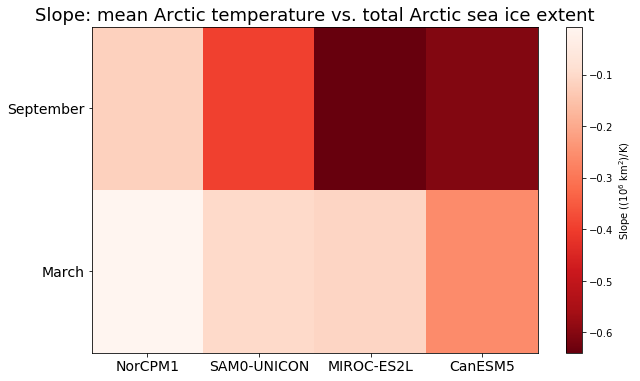

In [51]:
slopes_plot = np.zeros((2,len(slopes_all.keys())))

for im, m in enumerate(slopes_all.keys()):
    slopes_plot[0,im] = slopes_all[m][0]
    slopes_plot[1,im] = slopes_all[m][1]

fig = plt.figure(figsize=(10,6))
plt.pcolormesh(slopes_plot, cmap='Reds_r')
plt.xticks([0.5,1.5,2.5,3.5],list(slopes_all.keys()),fontsize=14)
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('Slope: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='Slope ((10$^{6}$ km$^{2}$)/K)')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


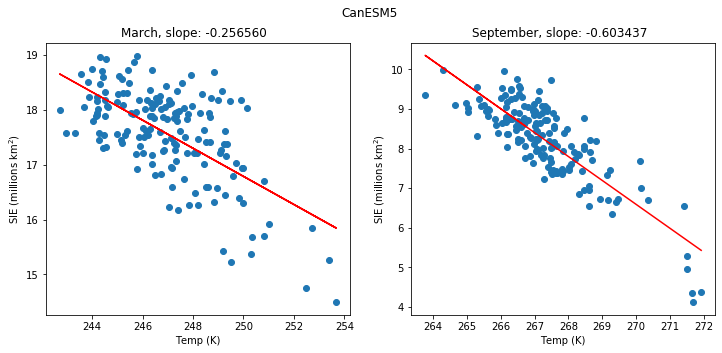

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


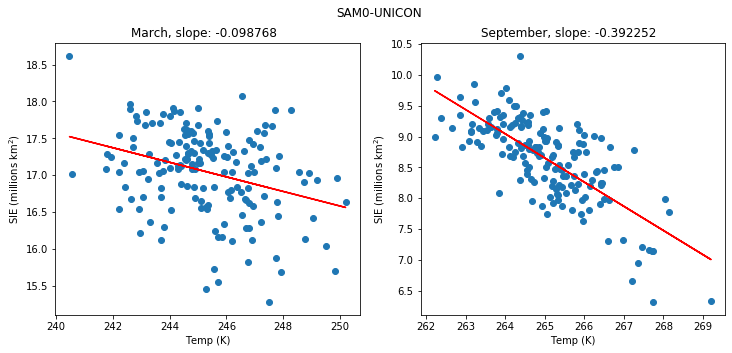

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


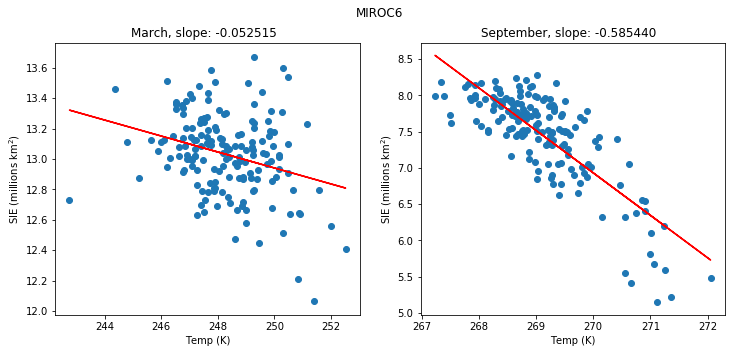

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [ ]:
for m in models_intersect:
    slopes_all[m], r_all[m] = scatter_tas_SIE_linreg(tas_dict[m]['tas_arc_mean'].isel(member_id=0),
                                                      si_dict[m]['sie_tot_arc'].isel(member_id=0),
                                                      [2,8],True,m)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


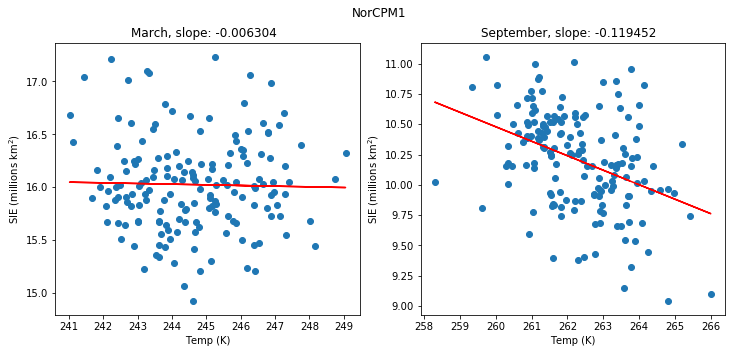

In [172]:
slopes_all[m], r_all[m] = scatter_tas_SIE_linreg(tas_dict[m]['tas_arc_mean'].isel(member_id=0),
                                                  si_dict[m]['sie_tot_arc'].isel(member_id=0),
                                                  [2,8],True,m)

In [173]:
slopes_plot = np.zeros((2,len(slopes_all.keys())))

for im, m in enumerate(slopes_all.keys()):
    slopes_plot[0,im] = slopes_all[m][0]
    slopes_plot[1,im] = slopes_all[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(slopes_plot, cmap='Reds_r')
plt.xticks([0.5,1.5,2.5,3.5],list(slopes_all.keys()),fontsize=14)
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('Slope: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='Slope ((10$^{6}$ km$^{2}$)/K)')

({'NorCPM1': [-0.006304150701190346, -0.1194523239842785]},
 {'NorCPM1': [-0.024048084867891974, -0.39030387557152413]})

In [ ]:
r_plot = np.zeros((2,len(r_all.keys())))

for im, m in enumerate(r_all.keys()):
    r_plot[0,im] = r_all[m][0]*r_all[m][0]
    r_plot[1,im] = r_all[m][1]*r_all[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(r_plot, cmap='Reds')
plt.xticks([0.5,1.5,2.5,3.5],list(slopes_all.keys()),fontsize=14)
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('R$^{2}$: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='R$^{2}$')

In [ ]:
for m in models_intersect:
    slopes_all[m], r_all[m] = scatter_tas_SIE_linreg(tas_dict[m]['tas_arc_mean'].isel(member_id=0),
                                                      si_dict[m]['sie_tot_arc'].isel(member_id=0),
                                                      [2,8],False,m)

### Get extent climatology

In [22]:
month_lab = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Text(0, 0.5, 'Arctic sea ice extent (m$^{2}$)')

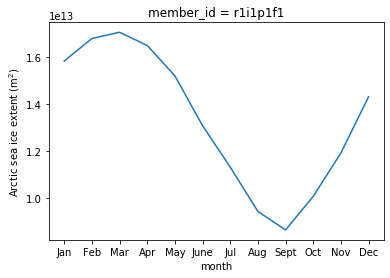

In [58]:
# si_mon = si_dict[m]['si_area_tot_arc']
# si_mon_mn = si_mon.groupby('time.month').mean('time').isel(member_id=0)
# si_mon_std = si_mon.groupby('time.month').std().isel(member_id=0)

sie_mon = si_dict[m]['sie_tot_arc']
sie_mon_mn = sie_mon.groupby('time.month').mean('time').isel(member_id=0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


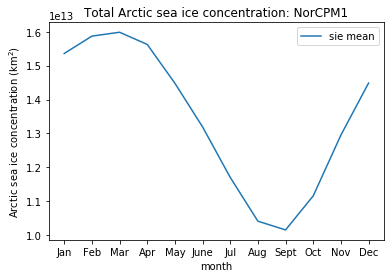

In [59]:
#si_mon_mn.plot(label='sia mean')
sie_mon_mn.plot(label='sie mean')
#plt.fill_between(si_mon_mn.month,si_mon_mn-2*si_mon_std,si_mon_mn+2*si_mon_std,alpha=0.3)
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic sea ice extent std (m$^{2}$)')

### Calculate average Arctic surface temperature

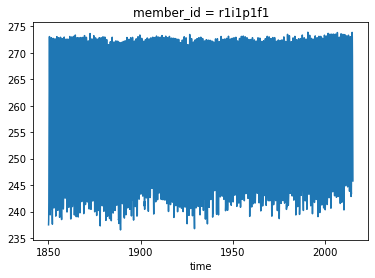

In [164]:
ts_tas_ArcticAve = si.arctic_mean(tas_dict[m],tas_dict[m]['tas'],70)
ts_tas_ArcticAve[0,:].plot()

### Get temperature climatology

Text(0, 0.5, 'Arctic average T (K)')

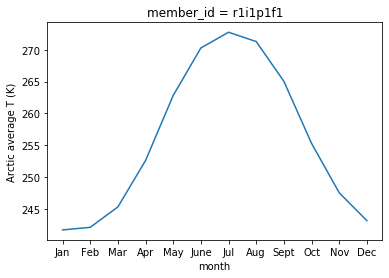

In [165]:
#Plot climatology
ts_mon_mn = ts_tas_ArcticAve.groupby('time.month').mean('time')
ts_mon_mn.plot()
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic average T (K)')

Text(0, 0.5, 'Arctic averate T std (K)')

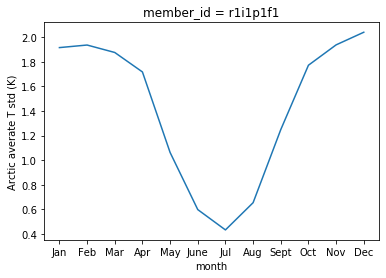

In [166]:
#Plot std in each month (does this look right?)
ts_mon_std = ts_tas_ArcticAve.groupby('time.month').std()
ts_mon_std.plot()
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic averate T std (K)')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater


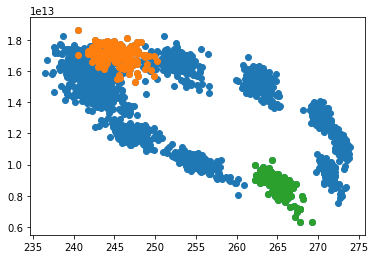

In [171]:
plt.scatter(ts_tas_ArcticAve[0,:],ts_Arctic_extent)
plt.scatter(ts_tas_ArcticAve[0,2::12],ts_Arctic_extent[2::12])
plt.scatter(ts_tas_ArcticAve[0,8::12],ts_Arctic_extent[8::12])

### Problems

In [173]:
#1.
    #m=1 (CESM2)
    #Plotting requires coordinates to be numeric or dates of type np.datetime64, datetime.datetime,
    #cftime.datetime or pd.Interval.
    

### To-do

In [174]:
#1. Calculate regression coefficients using sci-py

#2. Refactor so can loop over different models/scenarios

#3. Perform same process for different time periods
